# Introduction

## Brief Introduction:
From Alligator_v01, you can efficiently train a binary classifier model by different first-order gradient descent optimisation algorithms, such as 1) **Greedy**, 2) **Momentum**, 3) **RMSprop**, 4) **Adam**. And all optimisations speed up by **Mini-batch** algorithm. A regularisation technique **L2 regulariser** would help you to improve the test/dev set performance. At the end of this notebook, results from these five algorithms would allow you to select a suitable optimiser for you.<br>

## How to Use Alligator?
To train your data by Alligator, you only need to provide the training and testing datasets in a correct format, then, this system will help you learn automatically and provide the comparison results at the end of this notebook in term of **train accuracy** and **testing accuracy**.<br>

The input x should be flattened into a vector and in size of [$n_x, m$], where $n_x$ is the vectorised data for a single example, and $m$ is the number of the total examples. Then, pair with a labelled data (y) in size of [$1, m$].

## Network Architecture and Functions Used:
From this section, you will know the basic neural network architecture and the functions used to compute the cost, which could help you improve this model's performance.
1. Neural network architecture:
    - Inputs -> #[linear->Relu] -> [linear->Sigmoid] -> output
    - The number of the neurons on each layer, and the number of hidden layers can be defined by your requirement. Your only required to provide the nerons on variable.
2. Cost functions:
    - Cross-entropy to compute the cost:<br>
        $$ \text{cost} = - \frac{1}{m} \sum^m_{i=1} \sum^C_{j=1} y\log{\hat{y}} $$
    - L2 Penalty:<br>
        $$ \text{L2 cost} = \text{entropy cost}{red} + \text{L2 penalty}\\
        \text{penalty} = \frac{\lambda}{2m} \sum_l \sum_k\sum_j W_{k,j}^{[l]2} $$


## Techniques/Parameters you can tune to improve the performace:
1. **Learning rate**: - **'learning_rate = '**<br>
    -> rate affects the convergent speed, and also the the final result to opmital value or around it.
2. **Mini-batch size**: - **'mini_batch_size = '**
3. **Layer's dimensions**: - **'layer_dims = '**<br>
    -> #of neurons and #of layers can be considered in separate.
4. **Optimiser**: - **'optimiser = '**<br>
    -> Affect the speed and sometimes affect the accuracy<br>
    -> 'momentum', 'rmsprop', 'adam' can be selected
5. **Training time**: - **'num_epochs = '**
5. **Lambda** for L2 Regularisation:  - **'lambd = '** <br>
    -> Default set 'lambd = 0' to disable regularisation



# Model Structure
1. Section 1: Initialisation and Data Loading
    - Import library
    - Import data
    - Define parameters and layer's dimensions
2. Section 2: Network Architecture
3. Section 3: Train model 
    - print_cost = True, to visualise the cost tendency along with updating
4. Section 4: Comparison

In [1]:
# Import library
import numpy as np
from Hatchling_lib import *
import h5py #for data loading
import matplotlib.pyplot as plt # for plotting
import time

#matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


np.random.seed(1)

In [2]:
# Load data to test the optimisation performance from sklearn.datasets
import sklearn
import sklearn.datasets
def load_dataset(seed = 3, n_samples = 300): #Directly from sklearn in 2d points
    np.random.seed(seed)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples, noise=.2) #300 #0.2 
    # Visualize the data
    # plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

train_x, train_y = load_dataset(seed = 3, n_samples = 10000)
test_x, test_y = load_dataset(seed = 2, n_samples = 1000)

In [3]:
# Define parameters and layer's dimensions
layer_dims = [train_x.shape[0], 20, 5, 1]

# General set a following values:
beta_1 = 0.9 # Moving average step for Momentum optimisation, ie. averaging around 10 time scales
beta_2 = 0.999 # Moving step for RMSprop
epsilon = 1e-8 # To avoid denominator blow up in RMSprop


In [4]:
def Hatchling_model(X, Y, layer_dims, optimiser = 'gd', learning_rate = 0.005, 
                    lambd = 0, mini_batch_size = 64, beta1 = 0.9, beta2 = 0.999,  
                    epsilon = 1e-8, num_epochs = 5001, print_cost = True, plot_cost = False):

    """    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layer_dims -- python list, containing the size of each layer
    optimiser -- Updating model selection
    learning_rate -- the learning rate, scalar
    lambda -- L2 regularisation parameter, if =0, disable regularisaiton
    mini_batch_size -- the size of a mini batch
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs (i.e. #iterations of whole train set)
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """


    L = len(layer_dims)              # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    m = X.shape[1]                   # number of training examples
    grads = {}
    seed = 5                         # To get constant random value, can be disabled when train your own model
    
    
    # STEP 1: Initialise parameters
    parameters = initialise_parameters_deep(layer_dims)

    # Initialise the optimiser
    if optimiser == "gd":
        pass # no initialisation required for gradient descent, jump out this if-loop.
    elif optimiser == "momentum":
        v = initialise_velocity(parameters)
    elif optimiser == "RMSprop":
        s = initialise_RMSprop(parameters)
    elif optimiser == "adam":
        v, s = initialise_adam(parameters)
    
    # STEP 2: Optimisation loop
    for i in range(num_epochs):
        
        # Define the random minibatches. 
        # Increment the seed to reshuffle differently the dataset after each epoch.
        seed = seed + 1
        mini_batches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in mini_batches:
            
             # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            
            # STEP 2.1: Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            AL, caches = L_model_forward(minibatch_X, parameters)
        
        
            # STEP 2.2: Compute cost by Binary Cross-Entropy cost
            if lambd == 0: #i.e. no regularisation
                cost_total += bi_cross_entropy_cost(AL, minibatch_Y)
            else:
                cost_total += cost_L2regularisation(AL, minibatch_Y, parameters, lambd)
                
            
            # STEP 2.3: Backward propagation
            if lambd == 0:
                grads = L_model_backward(AL, minibatch_Y, caches)
            elif lambd != 0:
                grads = L_model_backward_L2regularisation(AL, minibatch_Y, caches, lambd)
            
            
            # STEP 2.4: Update parameters
            if optimiser == "gd":
                parameters = greedy_para_optimiser(parameters, grads, learning_rate)
            elif optimiser == "momentum":
                t = t + 1 # Bias Correction counter
                parameters, v = momentum_para_optimiser(parameters, grads, v, t, beta1, learning_rate)
            elif optimiser == "RMSprop":
                t = t + 1 # Bias Correction counter
                parameters, s = RMSprop_para_optimiser(parameters, grads, s, t, learning_rate, beta2, epsilon)
            elif optimiser == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = adam_para_optimiser(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
        
        
        cost_avg = cost_total / m # Average cost for each tain example
        
        
        # Print the cost every 1000 training example or stop 
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
            
    # plot the cost
    if plot_cost:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters
    
    

In [5]:
## Train and Test the Model with difference optimiser
 # Greedy gradient Descent
start_time1 = time.time()
print('Cost illustration for Gradient Descent:')
greedy_para = Hatchling_model(train_x, train_y, layer_dims=layer_dims, optimiser = 'gd', print_cost = True)
end_time1 = time.time()
t1 = end_time1 - start_time1
train_acc_greedy, pred_train_greedy = bi_Classfier_predict(train_x, train_y, greedy_para)
test_acc_greedy, pred_test_greedy = bi_Classfier_predict(train_x, train_y, greedy_para)

 # Greedy gradient Descent with L2 Regularisation
start_time2 = time.time()
print('Cost illustration for Gradient Descent with L2 regularisation:')
para_L2 = Hatchling_model(train_x, train_y, layer_dims=layer_dims, optimiser = 'gd', print_cost = True)
end_time2 = time.time()
t2 = end_time2 - start_time2
train_acc_L2, pred_train_L2 = bi_Classfier_predict(train_x, train_y, para_L2)
test_acc_L2, pred_test_L2 = bi_Classfier_predict(test_x, test_y, para_L2)

 # Gradient Descent by Momentum
start_time3 = time.time()
momentum_para = Hatchling_model(train_x, train_y, layer_dims=layer_dims, optimiser = 'momentum', print_cost = False)
end_time3 = time.time()
t3 = end_time3 - start_time3
train_acc_momentum, pred_train_momentum = bi_Classfier_predict(train_x, train_y, momentum_para)
test_acc_momentum, pred_test_momentum = bi_Classfier_predict(test_x, test_y, momentum_para)

 # Gradient Descent by RMSprop
start_time4 = time.time()
rmsprop_para = Hatchling_model(train_x, train_y, layer_dims = layer_dims, optimiser = 'RMSprop', print_cost = False)
end_time4 = time.time()
t4 = end_time4 - start_time4
train_acc_rms, pred_train_rms = bi_Classfier_predict(train_x, train_y, rmsprop_para)
test_acc_rms, pred_test_rms = bi_Classfier_predict(test_x, test_y, rmsprop_para)

 # Gradient Descent by Adam
start_time5 = time.time()
adam_para = Hatchling_model(train_x, train_y, layer_dims=layer_dims, optimiser = 'adam', print_cost = False)
end_time5 = time.time()
t5 = end_time5 - start_time5
train_acc_adam, pred_train_adam = bi_Classfier_predict(train_x, train_y, adam_para)
test_acc_adam, pred_test_adam = bi_Classfier_predict(test_x, test_y, adam_para)
    


Cost illustration for Gradient Descent:
Cost after epoch 0: 0.009169
Cost after epoch 1000: 0.001250
Cost after epoch 2000: 0.001251
Cost after epoch 3000: 0.001241
Cost after epoch 4000: 0.001245
Cost after epoch 5000: 0.001240
Cost illustration for Gradient Descent with L2 regularisation:
Cost after epoch 0: 0.009169
Cost after epoch 1000: 0.001250
Cost after epoch 2000: 0.001251
Cost after epoch 3000: 0.001241
Cost after epoch 4000: 0.001245
Cost after epoch 5000: 0.001240


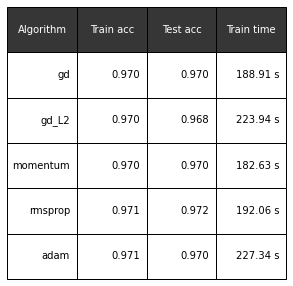

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
if __name__ == "__main__":    
    data = {"Algorithm": ['gd', 'gd_L2', 'momentum', 'rmsprop', 'adam'],
            "Train acc": [format(train_acc_greedy,'.3f'), format(train_acc_L2,'.3f'), format(train_acc_momentum,'.3f'), format(train_acc_rms,'.3f'), format(train_acc_adam,'.3f')],        
            "Test acc": [format(test_acc_greedy,'.3f'), format(test_acc_L2,'.3f'), format(test_acc_momentum,'.3f'), format(test_acc_rms,'.3f'), format(test_acc_adam,'.3f')],
            "Train time":[(format(t1,'.2f')+' s'), (format(t2,'.2f')+' s'), (format(t3,'.2f')+' s'), (format(t4,'.2f')+' s'), (format(t5,'.2f')+' s')]} 
    
    df = pd.DataFrame(data)    
    fig, ax = plt.subplots(figsize=(5, 5))    
    ax.axis("off")    
    ax.axis("tight")    
    tb = ax.table(cellText=df.values, colLabels=df.columns, bbox=[0, 0, 1, 1],)    
    tb[0, 0].set_facecolor("#363636")    
    tb[0, 1].set_facecolor("#363636")   
    tb[0, 2].set_facecolor("#363636")    
    tb[0, 0].set_text_props(color="w")    
    tb[0, 1].set_text_props(color="w")   
    tb[0, 2].set_text_props(color="w") 
    tb[0, 3].set_facecolor("#363636")    
    tb[0, 3].set_text_props(color="w")    
    
    plt.show()